# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.


## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-18 13:00:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2023-07-18 13:00:51 (65.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past almost 8 years but there is 2787 samples.

Typically deep learning models usually like lots and lots of samples (where lots and lots can thousands to ten of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


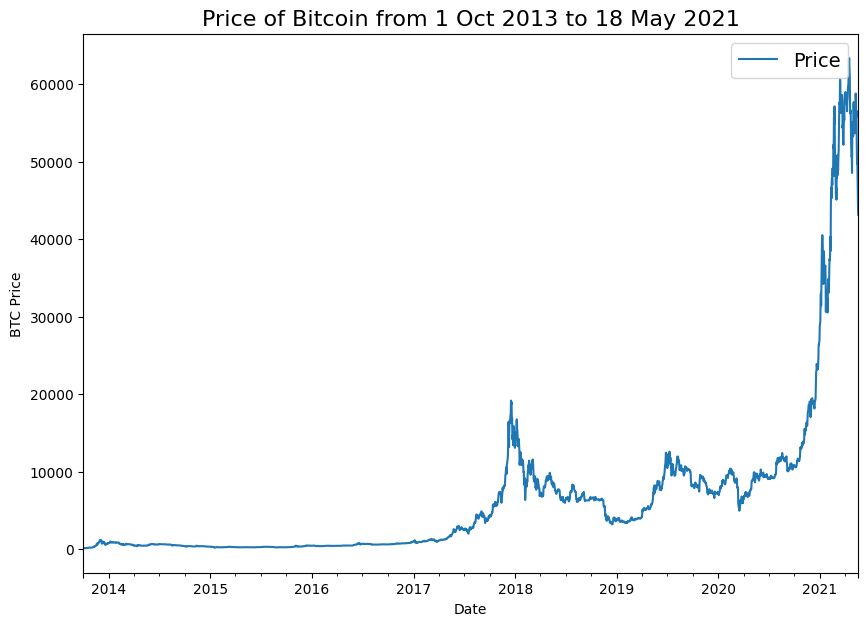

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [7]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

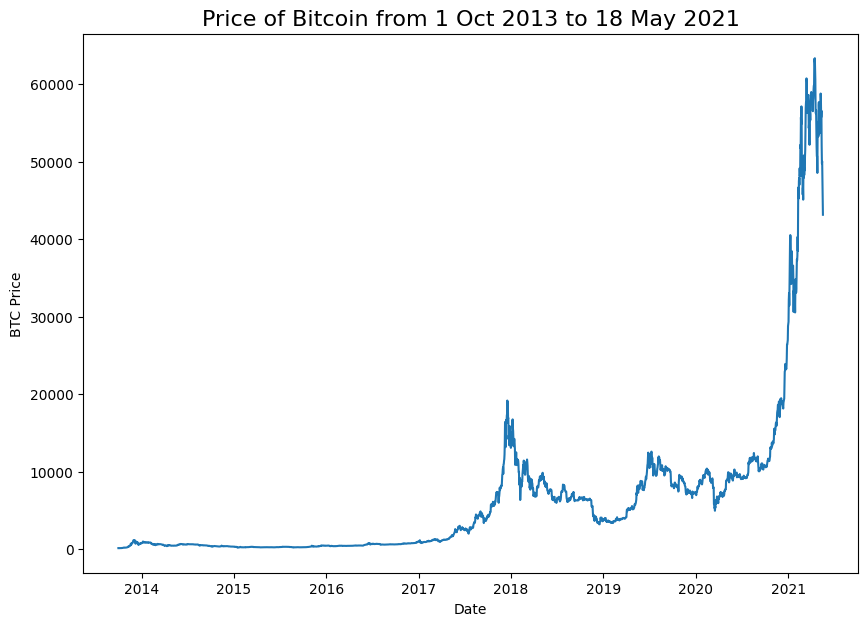

In [8]:
# Plot from CSV
import matplotlib.pyplot as plt
# import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

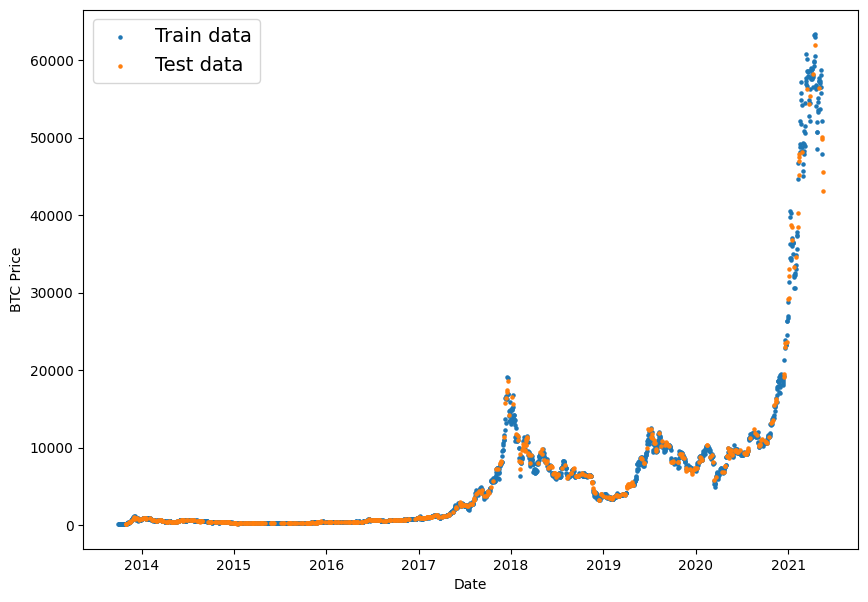

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

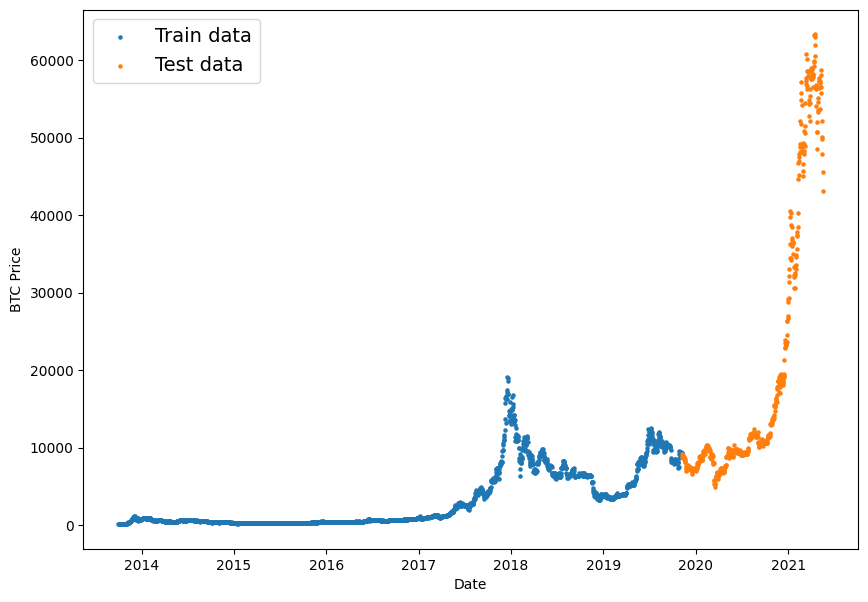

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters:
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

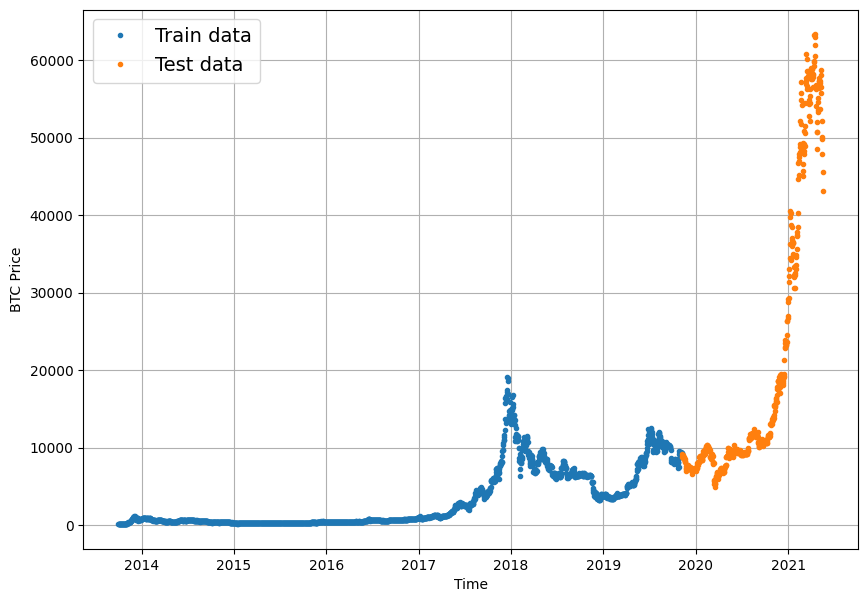

In [15]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0 Naive Bayes (baseline)
* 1 Dense Model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATS Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

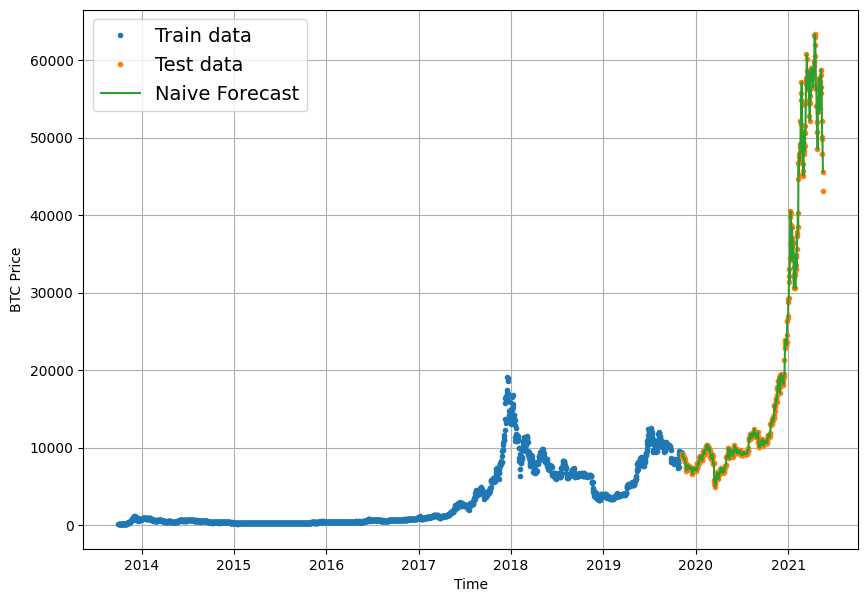

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

for all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [18]:
import tensorflow as tf

In [19]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [20]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

0.9995699939182624

In [21]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

Let's now see if it works...

In [22]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [24]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models.

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning algorithm.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]


In [25]:
len(y_train)

2229

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [28]:
# Create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label.numpy())}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite low.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [30]:
import numpy as np

In [31]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=HORIZON)
  return windows, labels

In [32]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [33]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [34]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets


In [35]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [36]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [37]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [38]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and RELU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* *Hyperparameters* = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own


In [39]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2422.4329 - mae: 2422.4329 - mse: 16370123.0000

18/18 [==============================] - 10s 107ms/step - loss: 2422.4329 - mae: 2422.4329 - mse: 16370123.0000 - val_loss: 3656.1055 - val_mae: 3656.1055 - val_mse: 25915640.0000
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 375.8961 - mae: 375.8961 - mse: 535732.5000

18/18 [==============================] - 1s 66ms/step - loss: 355.4249 - mae: 355.4249 - mse: 472718.7500 - val_loss: 1282.3269 - val_mae: 1282.3269 - val_mse: 4504230.5000
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 239.6856 - mae: 239.6856 - mse: 264874.6875

18/18 [==============================] - 1s 63ms/step - loss: 225.4734 - mae: 225.4734 - mse: 238099.8750 - val_loss: 1020.1724 - val_mae: 1020.1724 - val_mse: 3533321.0000
Epoch 4/100
 9/18 [==============>...............] - ETA: 0s - loss: 202.7208 - mae: 202.7208 - mse: 219977.3125

18/18 [==============================] - 1s 59ms/step - loss: 186.7738 - mae: 186.7738 - mse: 180096.1094 - val_loss: 997.9827 - val_mae: 997.9827 - val_mse: 3354693.5000
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 189.5251 - mae: 189.5251 - mse: 189233.0469

18/18 [==============================] - 1s 59ms/step - loss: 179.5782 - mae: 179.5782 - mse: 169403.2656 - val_loss: 989.0986 - val_mae: 989.0986 - val_mse: 3166500.5000
Epoch 6/100
10/18 [===============>..............] - ETA: 0s - loss: 173.2317 - mae: 173.2317 - mse: 147965.7812

18/18 [==============================] - 1s 65ms/step - loss: 174.5882 - mae: 174.5882 - mse: 160398.3594 - val_loss: 957.5525 - val_mae: 957.5525 - val_mse: 3104699.0000
Epoch 7/100
 9/18 [==============>...............] - ETA: 0s - loss: 184.0691 - mae: 184.0691 - mse: 185698.6875

18/18 [==============================] - 1s 65ms/step - loss: 167.1395 - mae: 167.1395 - mse: 149700.8438 - val_loss: 921.4501 - val_mae: 921.4501 - val_mse: 2722006.5000
Epoch 8/100
 9/18 [==============>...............] - ETA: 0s - loss: 155.8958 - mae: 155.8958 - mse: 117522.5859

18/18 [==============================] - 1s 64ms/step - loss: 160.0252 - mae: 160.0252 - mse: 139061.6250 - val_loss: 878.4777 - val_mae: 878.4777 - val_mse: 2578740.7500
Epoch 9/100
18/18 [==============================] - 0s 13ms/step - loss: 158.1308 - mae: 158.1308 - mse: 135529.3906 - val_loss: 904.5565 - val_mae: 904.5565 - val_mse: 2540239.2500
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 150.5076 - mae: 150.5076 - mse: 117929.0547

18/18 [==============================] - 2s 100ms/step - loss: 154.7234 - mae: 154.7234 - mse: 130767.9453 - val_loss: 840.4754 - val_mae: 840.4754 - val_mse: 2356838.0000
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 149.6450 - mae: 149.6450 - mse: 123632.8906

18/18 [==============================] - 2s 88ms/step - loss: 150.8864 - mae: 150.8864 - mse: 123715.9297 - val_loss: 824.8139 - val_mae: 824.8140 - val_mse: 2251191.7500
Epoch 12/100
18/18 [==============================] - 0s 17ms/step - loss: 147.4162 - mae: 147.4162 - mse: 118854.3047 - val_loss: 861.1811 - val_mae: 861.1811 - val_mse: 2268464.2500
Epoch 13/100
18/18 [==============================] - 0s 18ms/step - loss: 146.4675 - mae: 146.4675 - mse: 119846.4297 - val_loss: 831.0982 - val_mae: 831.0982 - val_mse: 2148904.2500
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 139.3593 - mae: 139.3593 - mse: 105360.0000

18/18 [==============================] - 1s 84ms/step - loss: 142.3280 - mae: 142.3280 - mse: 111242.1016 - val_loss: 806.9250 - val_mae: 806.9250 - val_mse: 2047009.3750
Epoch 15/100
14/18 [======================>.......] - ETA: 0s - loss: 139.9103 - mae: 139.9103 - mse: 113736.7578

18/18 [==============================] - 1s 70ms/step - loss: 139.0727 - mae: 139.0727 - mse: 108077.7969 - val_loss: 776.3205 - val_mae: 776.3205 - val_mse: 1936667.8750
Epoch 16/100
18/18 [==============================] - 0s 8ms/step - loss: 135.4870 - mae: 135.4870 - mse: 103010.2266 - val_loss: 790.9893 - val_mae: 790.9893 - val_mse: 1940348.1250
Epoch 17/100
18/18 [==============================] - 0s 11ms/step - loss: 136.2703 - mae: 136.2703 - mse: 102000.8672 - val_loss: 794.8365 - val_mae: 794.8365 - val_mse: 1929492.0000
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 138.0859 - mae: 138.0859 - mse: 106030.0469

18/18 [==============================] - 1s 55ms/step - loss: 136.9805 - mae: 136.9805 - mse: 104810.1250 - val_loss: 742.7333 - val_mae: 742.7333 - val_mse: 1766728.7500
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 131.4170 - mae: 131.4170 - mse: 97227.0000 - val_loss: 747.0616 - val_mae: 747.0616 - val_mse: 1758832.0000
Epoch 20/100
15/18 [========================>.....] - ETA: 0s - loss: 135.0909 - mae: 135.0909 - mse: 101617.1484

18/18 [==============================] - 1s 57ms/step - loss: 135.5517 - mae: 135.5517 - mse: 101824.5469 - val_loss: 713.6844 - val_mae: 713.6844 - val_mse: 1725172.7500
Epoch 21/100
10/18 [===============>..............] - ETA: 0s - loss: 139.9933 - mae: 139.9933 - mse: 100792.2031

18/18 [==============================] - 1s 68ms/step - loss: 132.2381 - mae: 132.2381 - mse: 98261.4531 - val_loss: 692.0905 - val_mae: 692.0905 - val_mse: 1623827.0000
Epoch 22/100
11/18 [=================>............] - ETA: 0s - loss: 139.5783 - mae: 139.5783 - mse: 113185.9922

18/18 [==============================] - 1s 67ms/step - loss: 127.9010 - mae: 127.9010 - mse: 94009.3203 - val_loss: 684.0209 - val_mae: 684.0209 - val_mse: 1589846.3750
Epoch 23/100
 9/18 [==============>...............] - ETA: 0s - loss: 125.0792 - mae: 125.0792 - mse: 82815.0781

18/18 [==============================] - 1s 58ms/step - loss: 125.4177 - mae: 125.4177 - mse: 91260.7188 - val_loss: 674.1341 - val_mae: 674.1341 - val_mse: 1537274.5000
Epoch 24/100
18/18 [==============================] - 0s 10ms/step - loss: 123.0968 - mae: 123.0968 - mse: 87788.9766 - val_loss: 693.4222 - val_mae: 693.4222 - val_mse: 1558383.8750
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 124.6501 - mae: 124.6501 - mse: 88682.3750

18/18 [==============================] - 2s 131ms/step - loss: 121.7371 - mae: 121.7371 - mse: 86819.5156 - val_loss: 659.2157 - val_mae: 659.2157 - val_mse: 1481263.6250
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 125.4904 - mae: 125.4904 - mse: 85670.7500

18/18 [==============================] - 1s 67ms/step - loss: 121.3121 - mae: 121.3121 - mse: 85629.8125 - val_loss: 653.4256 - val_mae: 653.4256 - val_mse: 1459434.6250
Epoch 27/100
18/18 [==============================] - 0s 11ms/step - loss: 121.6364 - mae: 121.6364 - mse: 85340.5312 - val_loss: 655.7125 - val_mae: 655.7125 - val_mse: 1450373.7500
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 119.9285 - mae: 119.9285 - mse: 83433.9141

18/18 [==============================] - 1s 72ms/step - loss: 119.9014 - mae: 119.9014 - mse: 82590.1328 - val_loss: 644.1392 - val_mae: 644.1392 - val_mse: 1422002.1250
Epoch 29/100
18/18 [==============================] - 0s 13ms/step - loss: 118.2654 - mae: 118.2654 - mse: 82801.1406 - val_loss: 657.3488 - val_mae: 657.3488 - val_mse: 1437911.7500
Epoch 30/100
18/18 [==============================] - 0s 9ms/step - loss: 123.5663 - mae: 123.5663 - mse: 85372.9609 - val_loss: 673.5199 - val_mae: 673.5199 - val_mse: 1471962.8750
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 133.5275 - mae: 133.5275 - mse: 91067.7344 - val_loss: 879.8286 - val_mae: 879.8286 - val_mse: 2091311.0000
Epoch 32/100
18/18 [==============================] - 0s 8ms/step - loss: 131.5561 - mae: 131.5561 - mse: 87493.9688 - val_loss: 660.5414 - val_mae: 660.5414 - val_mse: 1430743.0000
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 119.2377 - mae: 119.2377 - 

18/18 [==============================] - 1s 54ms/step - loss: 119.9732 - mae: 119.9732 - mse: 83131.3750 - val_loss: 633.3723 - val_mae: 633.3723 - val_mse: 1365613.6250
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 118.2520 - mae: 118.2520 - mse: 81818.0469 - val_loss: 634.6982 - val_mae: 634.6982 - val_mse: 1363599.2500
Epoch 36/100
18/18 [==============================] - 0s 9ms/step - loss: 124.8991 - mae: 124.8991 - mse: 83431.6484 - val_loss: 708.4029 - val_mae: 708.4029 - val_mse: 1535914.3750
Epoch 37/100
18/18 [==============================] - ETA: 0s - loss: 118.9861 - mae: 118.9861 - mse: 80426.1250

18/18 [==============================] - 1s 76ms/step - loss: 118.9861 - mae: 118.9861 - mse: 80426.1250 - val_loss: 620.1558 - val_mae: 620.1558 - val_mse: 1334268.3750
Epoch 38/100
18/18 [==============================] - 0s 10ms/step - loss: 115.1772 - mae: 115.1772 - mse: 79319.8672 - val_loss: 637.1118 - val_mae: 637.1118 - val_mse: 1393015.0000
Epoch 39/100
18/18 [==============================] - 0s 10ms/step - loss: 115.7880 - mae: 115.7880 - mse: 78695.6250 - val_loss: 653.6104 - val_mae: 653.6104 - val_mse: 1444011.8750
Epoch 40/100
14/18 [======================>.......] - ETA: 0s - loss: 114.7917 - mae: 114.7917 - mse: 80300.6172 

18/18 [==============================] - 1s 53ms/step - loss: 113.5419 - mae: 113.5419 - mse: 77606.3125 - val_loss: 613.8660 - val_mae: 613.8660 - val_mse: 1308245.6250
Epoch 41/100
18/18 [==============================] - 0s 19ms/step - loss: 113.5084 - mae: 113.5084 - mse: 76987.8672 - val_loss: 651.4575 - val_mae: 651.4575 - val_mse: 1432128.8750
Epoch 42/100
18/18 [==============================] - 0s 12ms/step - loss: 119.8944 - mae: 119.8944 - mse: 80115.5547 - val_loss: 631.7833 - val_mae: 631.7833 - val_mse: 1370476.1250
Epoch 43/100
11/18 [=================>............] - ETA: 0s - loss: 108.1627 - mae: 108.1627 - mse: 65628.3594

18/18 [==============================] - 1s 60ms/step - loss: 113.7143 - mae: 113.7143 - mse: 77603.7969 - val_loss: 611.0594 - val_mae: 611.0594 - val_mse: 1309372.1250
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 110.7532 - mae: 110.7532 - mse: 75181.8281

18/18 [==============================] - 1s 66ms/step - loss: 113.4642 - mae: 113.4642 - mse: 75937.1094 - val_loss: 610.1376 - val_mae: 610.1376 - val_mse: 1306412.5000
Epoch 45/100
10/18 [===============>..............] - ETA: 0s - loss: 115.2882 - mae: 115.2882 - mse: 78761.2656

18/18 [==============================] - 3s 170ms/step - loss: 112.2574 - mae: 112.2574 - mse: 75980.7578 - val_loss: 606.1963 - val_mae: 606.1963 - val_mse: 1281711.2500
Epoch 46/100
10/18 [===============>..............] - ETA: 0s - loss: 120.2900 - mae: 120.2900 - mse: 90997.1250

18/18 [==============================] - 1s 82ms/step - loss: 113.4868 - mae: 113.4868 - mse: 76096.4688 - val_loss: 604.7297 - val_mae: 604.7297 - val_mse: 1290061.3750
Epoch 47/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4594 - mae: 113.4594 - mse: 76406.6094 - val_loss: 681.2258 - val_mae: 681.2258 - val_mse: 1432750.5000
Epoch 48/100
14/18 [======================>.......] - ETA: 0s - loss: 112.1362 - mae: 112.1362 - mse: 78694.0781

18/18 [==============================] - 1s 35ms/step - loss: 113.2692 - mae: 113.2692 - mse: 75101.1250 - val_loss: 601.5826 - val_mae: 601.5826 - val_mse: 1266020.1250
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3142 - mae: 113.3142 - mse: 75744.7969 - val_loss: 652.2485 - val_mae: 652.2485 - val_mse: 1361710.5000
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 141.3173 - mae: 141.3173 - mse: 149295.5000

18/18 [==============================] - 1s 31ms/step - loss: 116.7442 - mae: 116.7442 - mse: 77083.5859 - val_loss: 599.2046 - val_mae: 599.2046 - val_mse: 1275609.3750
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1108 - mae: 113.1108 - mse: 75994.5391 - val_loss: 610.5317 - val_mae: 610.5317 - val_mse: 1273690.5000
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2351 - mae: 115.2351 - mse: 78160.9609 - val_loss: 603.1225 - val_mae: 603.1225 - val_mse: 1282650.5000
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5857 - mae: 113.5857 - mse: 75794.8828 - val_loss: 631.0119 - val_mae: 631.0119 - val_mse: 1311853.3750
Epoch 54/100
16/18 [=========================>....] - ETA: 0s - loss: 112.8101 - mae: 112.8101 - mse: 76782.3906

18/18 [==============================] - 1s 31ms/step - loss: 112.1451 - mae: 112.1451 - mse: 73914.1406 - val_loss: 593.2818 - val_mae: 593.2818 - val_mse: 1256714.0000
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 127.4019 - mae: 127.4019 - mse: 100087.2891

18/18 [==============================] - 1s 31ms/step - loss: 116.2849 - mae: 116.2849 - mse: 79014.9531 - val_loss: 591.3625 - val_mae: 591.3625 - val_mse: 1250431.2500
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 111.7627 - mae: 111.7627 - mse: 74829.3672 - val_loss: 796.2121 - val_mae: 796.2120 - val_mse: 1858807.0000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 134.9076 - mae: 134.9076 - mse: 92172.1016 - val_loss: 705.9233 - val_mae: 705.9233 - val_mse: 1561701.2500
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 122.1030 - mae: 122.1030 - mse: 80690.5938 - val_loss: 715.0489 - val_mae: 715.0489 - val_mse: 1591720.7500
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4520 - mae: 111.4520 - mse: 73171.1016 - val_loss: 625.8629 - val_mae: 625.8629 - val_mse: 1335711.1250
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 115.3615 - mae: 115.3615 - m

18/18 [==============================] - 1s 31ms/step - loss: 114.7312 - mae: 114.7312 - mse: 75495.3750 - val_loss: 584.1071 - val_mae: 584.1071 - val_mse: 1223502.6250
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 115.4680 - mae: 115.4680 - mse: 74414.3359 - val_loss: 589.6108 - val_mae: 589.6108 - val_mse: 1244885.0000
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2619 - mae: 108.2619 - mse: 71076.5781 - val_loss: 596.1593 - val_mae: 596.1593 - val_mse: 1259624.1250
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1064 - mae: 113.1064 - mse: 71551.9766 - val_loss: 641.4966 - val_mae: 641.4966 - val_mse: 1364370.0000
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 122.7626 - mae: 122.7626 - mse: 80467.7500 - val_loss: 643.0797 - val_mae: 643.0797 - val_mse: 1368421.8750
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 126.6108 - mae: 126.6108 - m

18/18 [==============================] - 1s 31ms/step - loss: 109.5995 - mae: 109.5995 - mse: 72461.2812 - val_loss: 583.1892 - val_mae: 583.1892 - val_mse: 1214168.3750
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 109.0210 - mae: 109.0210 - mse: 72067.0781 - val_loss: 584.1530 - val_mae: 584.1530 - val_mse: 1226968.8750
Epoch 74/100
17/18 [===========================>..] - ETA: 0s - loss: 107.8641 - mae: 107.8641 - mse: 72388.7969 

18/18 [==============================] - 1s 33ms/step - loss: 108.0898 - mae: 108.0898 - mse: 72150.4609 - val_loss: 582.4513 - val_mae: 582.4513 - val_mse: 1221495.7500
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 108.6430 - mae: 108.6430 - mse: 71704.8047 - val_loss: 583.5766 - val_mae: 583.5766 - val_mse: 1212873.6250
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 76.2450 - mae: 76.2450 - mse: 25747.8047

18/18 [==============================] - 1s 31ms/step - loss: 109.4761 - mae: 109.4761 - mse: 72747.6797 - val_loss: 581.5253 - val_mae: 581.5253 - val_mse: 1216834.5000
Epoch 77/100
18/18 [==============================] - ETA: 0s - loss: 108.7942 - mae: 108.7942 - mse: 71675.1172

18/18 [==============================] - 1s 32ms/step - loss: 108.7942 - mae: 108.7942 - mse: 71675.1172 - val_loss: 579.4719 - val_mae: 579.4719 - val_mse: 1209468.6250
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 110.4872 - mae: 110.4872 - mse: 71228.4453 - val_loss: 581.6705 - val_mae: 581.6705 - val_mse: 1221683.6250
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3812 - mae: 109.3812 - mse: 73589.7578 - val_loss: 618.3677 - val_mae: 618.3677 - val_mse: 1302662.6250
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 117.4440 - mae: 117.4440 - mse: 122393.7578

18/18 [==============================] - 1s 32ms/step - loss: 109.8513 - mae: 109.8513 - mse: 72958.2734 - val_loss: 578.8506 - val_mae: 578.8506 - val_mse: 1204064.7500
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 91.1903 - mae: 91.1903 - mse: 42501.9727

18/18 [==============================] - 1s 62ms/step - loss: 106.3985 - mae: 106.3985 - mse: 70500.7500 - val_loss: 577.2998 - val_mae: 577.2998 - val_mse: 1202735.3750
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6671 - mae: 115.6671 - mse: 77276.7188 - val_loss: 578.3804 - val_mae: 578.3804 - val_mse: 1208971.1250
Epoch 83/100
18/18 [==============================] - 0s 18ms/step - loss: 110.6616 - mae: 110.6616 - mse: 73348.4922 - val_loss: 625.4587 - val_mae: 625.4587 - val_mse: 1318266.2500
Epoch 84/100
18/18 [==============================] - 0s 15ms/step - loss: 111.7278 - mae: 111.7278 - mse: 71640.7266 - val_loss: 591.1295 - val_mae: 591.1295 - val_mse: 1239621.7500
Epoch 85/100
18/18 [==============================] - 0s 18ms/step - loss: 107.8833 - mae: 107.8833 - mse: 71544.2969 - val_loss: 580.9258 - val_mae: 580.9258 - val_mse: 1201213.2500
Epoch 86/100
18/18 [==============================] - 0s 11ms/step - loss: 108.9725 - mae: 108.9725

18/18 [==============================] - 1s 56ms/step - loss: 108.8417 - mae: 108.8417 - mse: 71336.5000 - val_loss: 575.0798 - val_mae: 575.0798 - val_mse: 1202436.3750
Epoch 89/100
18/18 [==============================] - 0s 6ms/step - loss: 106.5950 - mae: 106.5950 - mse: 69621.8281 - val_loss: 576.1492 - val_mae: 576.1492 - val_mse: 1195454.6250
Epoch 90/100
18/18 [==============================] - 0s 11ms/step - loss: 106.0327 - mae: 106.0327 - mse: 67870.3438 - val_loss: 587.4504 - val_mae: 587.4504 - val_mse: 1210237.0000
Epoch 91/100
16/18 [=========================>....] - ETA: 0s - loss: 108.2771 - mae: 108.2771 - mse: 69761.3359

18/18 [==============================] - 2s 92ms/step - loss: 109.6821 - mae: 109.6821 - mse: 71933.2734 - val_loss: 573.9337 - val_mae: 573.9337 - val_mse: 1192199.2500
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2782 - mae: 111.2782 - mse: 73462.0625 - val_loss: 593.4636 - val_mae: 593.4636 - val_mse: 1239771.5000
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 118.4287 - mae: 118.4287 - mse: 77154.1562 - val_loss: 677.0072 - val_mae: 677.0072 - val_mse: 1441291.2500
Epoch 94/100
18/18 [==============================] - 0s 12ms/step - loss: 112.9412 - mae: 112.9412 - mse: 73877.9141 - val_loss: 581.9929 - val_mae: 581.9929 - val_mse: 1199976.5000
Epoch 95/100
18/18 [==============================] - 0s 9ms/step - loss: 107.5143 - mae: 107.5143 - mse: 70250.7812 - val_loss: 575.5001 - val_mae: 575.5001 - val_mse: 1191183.0000
Epoch 96/100
18/18 [==============================] - 0s 12ms/step - loss: 113.7357 - mae: 113.7357 -

18/18 [==============================] - 1s 48ms/step - loss: 111.2759 - mae: 111.2759 - mse: 73449.3594 - val_loss: 573.2554 - val_mae: 573.2554 - val_mse: 1196078.6250
Epoch 98/100
18/18 [==============================] - 0s 10ms/step - loss: 108.4308 - mae: 108.4308 - mse: 70532.7891 - val_loss: 596.4849 - val_mae: 596.4849 - val_mse: 1223815.0000
Epoch 99/100
18/18 [==============================] - 0s 13ms/step - loss: 109.3341 - mae: 109.3341 - mse: 70996.6562 - val_loss: 573.4048 - val_mae: 573.4048 - val_mse: 1188519.6250
Epoch 100/100
18/18 [==============================] - 0s 12ms/step - loss: 106.3412 - mae: 106.3412 - mse: 69599.0469 - val_loss: 586.9995 - val_mae: 586.9995 - val_mse: 1206376.7500


In [40]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 586.9995 - mae: 586.9995 - mse: 1206377.1250


[586.9994506835938, 586.9994506835938, 1206377.125]

In [41]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 573.2556 - mae: 573.2556 - mse: 1196079.2500


[573.2555541992188, 573.2555541992188, 1196079.25]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions.



In [42]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [43]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8895.971, 8797.294, 9067.603, 8832.824, 8754.027, 8786.213,
        8709.512, 8545.429, 8496.881, 8554.4  ], dtype=float32)>)

In [44]:
# test_labels.shape 556,1 oldugu icin istedigimiz sonucu alamiyoruz bundan dolayı tf.squeeze kullanmaliyiz.
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [45]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 573.25555,
 'mse': 1196079.2,
 'rmse': 1093.654,
 'mape': 2.5605817,
 'mase': 1.0070512}

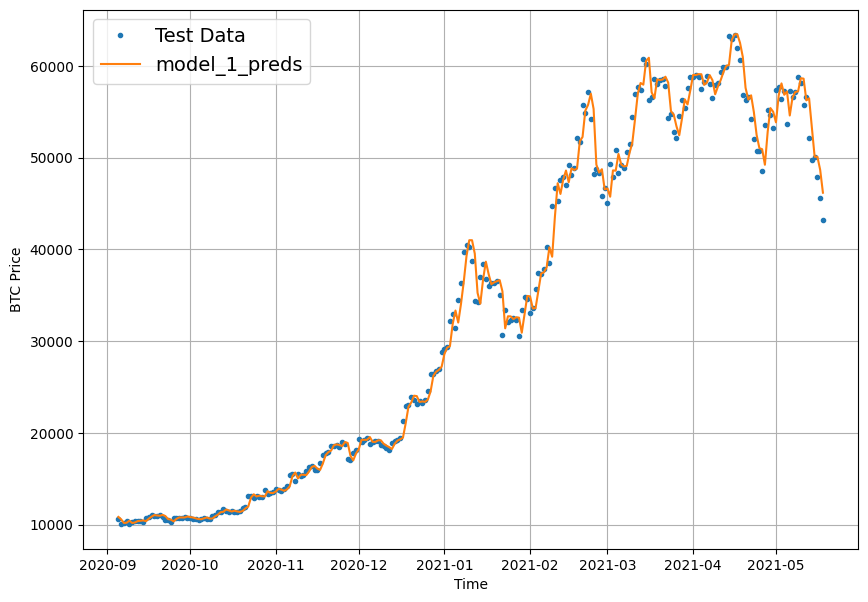

In [46]:
# Let's plot our model 1 predictions
offset=300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window=30, horizon=1)

In [47]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [48]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [49]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [50]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [51]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 621.6465


621.646484375

In [52]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 618.4468


618.44677734375

In [53]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [54]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 618.4467,
 'mse': 1341360.0,
 'rmse': 1158.1709,
 'mape': 2.770326,
 'mase': 1.081051}

In [55]:
model_1_results

{'mae': 573.25555,
 'mse': 1196079.2,
 'rmse': 1093.654,
 'mape': 2.5605817,
 'mase': 1.0070512}

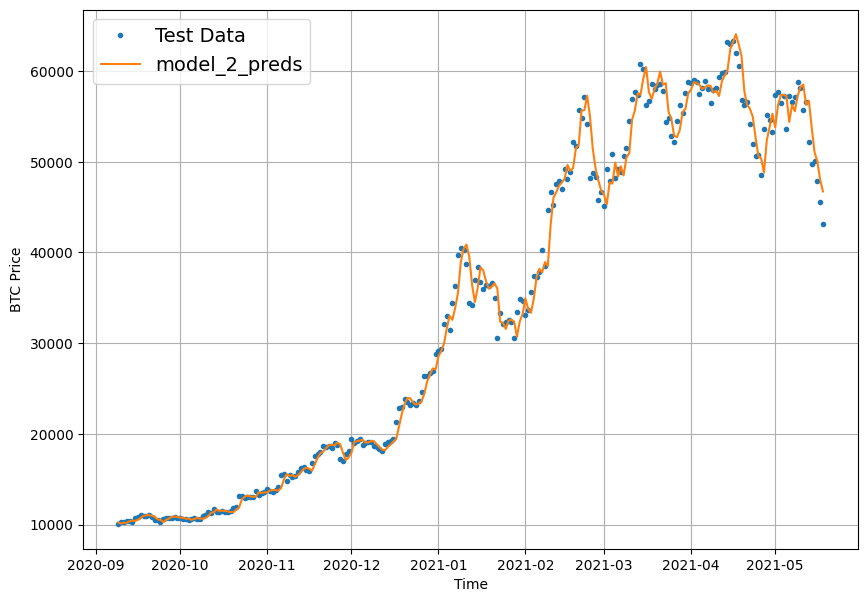

In [56]:
offset=300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window=30, horizon=7)



In [57]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [58]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [59]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [60]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1300.9888


1300.98876953125

In [61]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1218.8872


1218.88720703125

In [62]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9458.513, 9494.7  , 9424.276, 9149.484, 9455.11 , 9438.914,
        9547.26 ],
       [9051.667, 8912.519, 9128.469, 9019.421, 8940.23 , 9150.789,
        9250.198],
       [8792.871, 8669.964, 8808.495, 9077.803, 8923.486, 8963.901,
        9103.253],
       [8908.669, 8922.102, 8938.502, 9184.503, 9228.246, 9036.848,
        9288.056],
       [8778.317, 8913.847, 8826.666, 8827.072, 9213.107, 8742.971,
        8977.511]], dtype=float32)>

In [63]:
model_3_preds.shape

TensorShape([551, 7])

In [64]:
# Evaluate model_3 results # bu istedigimiz bir sonuc degil ve shape uyusmazligi var bu yuzden evaluation function'i guncelleyecegiz
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 630.82184 ,  361.69125 ,  295.648   ,  445.82324 ,  342.72238 ,
         455.97787 ,  514.68945 ,  450.1556  ,  438.46072 ,  451.45627 ,
         687.2027  ,  834.0731  ,  865.799   ,  885.96936 ,  568.8698  ,
         224.85295 ,  265.06558 ,  289.55475 ,  285.92654 ,  240.6617  ,
         142.06885 ,  180.82555 ,  298.331   ,  289.02505 ,  121.938126,
         138.19162 ,  143.89795 ,  143.41238 ,  116.20592 ,  144.84187 ,
         293.85922 ,  370.26724 ,  278.78314 ,  291.4069  ,  249.86781 ,
         272.62766 ,  307.94476 ,  244.55734 ,  241.54457 ,  317.77887 ,
         561.98285 ,  142.39719 ,   56.76116 ,   69.111465,  165.77957 ,
          58.154785,   66.84877 ,  112.51095 ,   90.26744 ,   68.081894,
          78.6928  ,   87.71317 ,  209.76472 ,  173.90443 ,  270.75098 ,
         322.77106 ,  609.0665  ,  551.0592  ,  470.5247  ,  571.04083 ,
         346.37424 ,  187.84236 ,  259.44064 ,  362.72287 ,  468.27008 ,
         440.51736 ,  498.49518 ,  555.43506

## Make our evaluation function work for larger horizons

In [65]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape= tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [66]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1218.8871,
 'mse': 5204047.5,
 'rmse': 1403.9066,
 'mape': 5.464689,
 'mase': 2.1689415}

We've made and evalauted predictions with `model_3`, let's visualize, visualize, visualize!

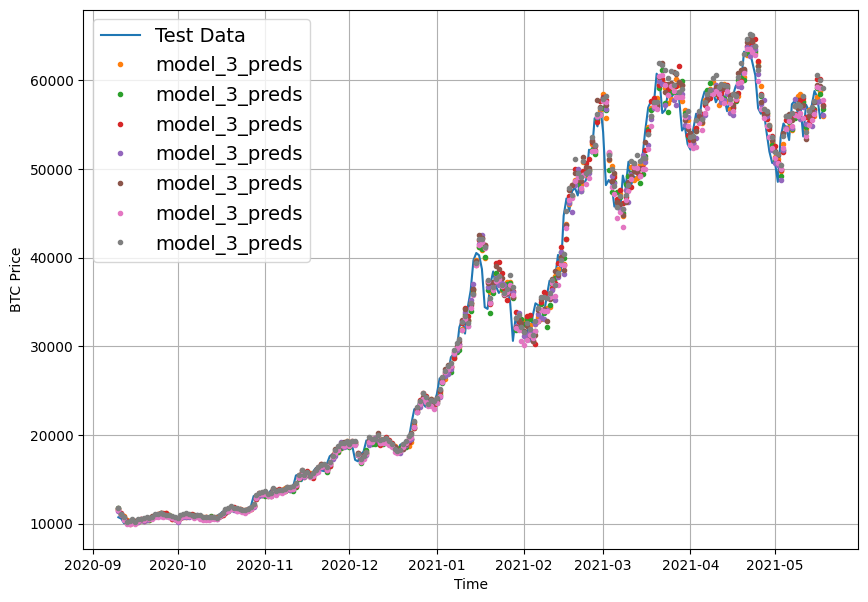

In [67]:
offset=300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds,
                 start=offset,
                 label="model_3_preds")

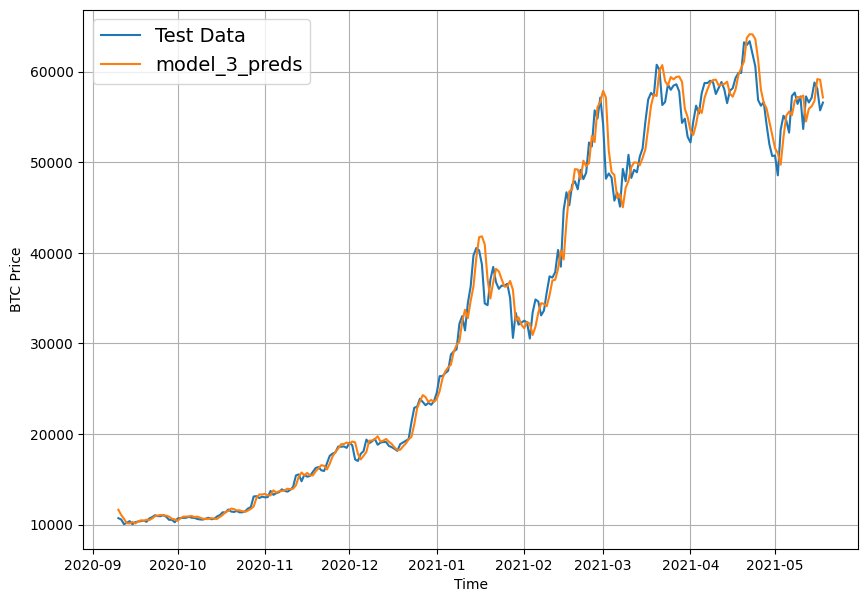

In [68]:
offset=300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="model_3_preds")

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

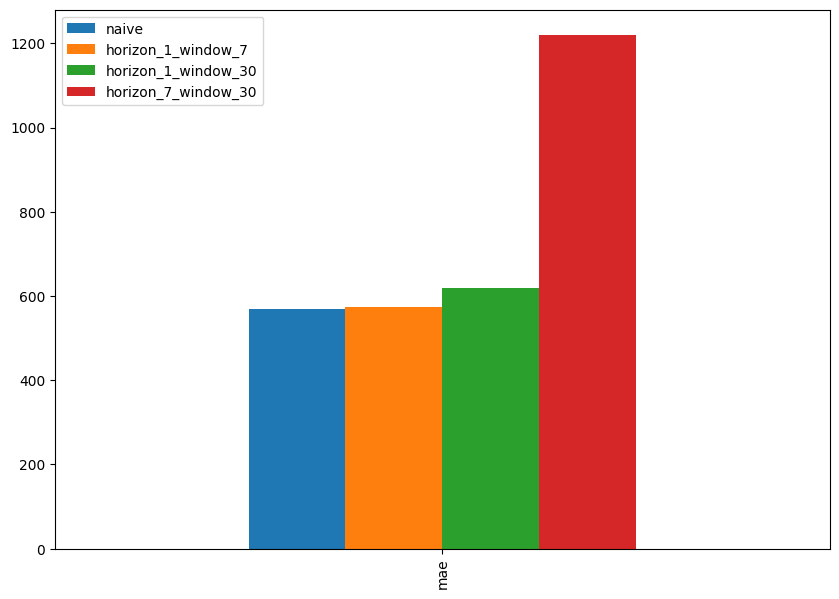

In [69]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

**Note:** You might be wondering, why are the naive results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

## Model 4: Conv1D



In [70]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [71]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [72]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [73]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [74]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [75]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [76]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [77]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [78]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Evaluate model...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 635.3969


635.3969116210938

In [80]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 571.6279


571.6279296875

In [81]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8896.127 ,  8782.041 ,  8991.979 ,  8805.085 ,  8736.932 ,
        8730.47  ,  8680.914 ,  8545.813 ,  8452.844 ,  8516.218 ,
        8285.1   ,  8122.6206,  8063.1133,  7714.245 ,  7333.8022,
        7246.903 ,  7082.5654,  7147.5347,  7131.983 ,  7418.6025,
        7445.767 ,  7655.6826,  7621.914 ,  7433.406 ,  7358.1196,
        7308.328 ,  7246.469 ,  7339.947 ,  7485.4565,  7542.291 ,
        7561.3086,  7394.6953,  7268.239 ,  7203.0347,  7184.344 ,
        7223.2036,  7116.989 ,  7100.6934,  6935.8887,  6645.4526,
        7200.988 ,  7232.9614,  7163.2563,  7252.0557,  7255.012 ,
        7226.7354,  7209.4478,  7224.2227,  7201.7065,  7217.7437,
        7294.6665,  7381.562 ,  7296.457 ,  7201.0854,  7176.347 ,
        7009.7627,  7202.8433,  7329.937 ,  7359.764 ,  7640.975 ,
        7985.207 ,  8119.886 ,  7908.779 ,  8032.7817,  8112.289 ,
        8159.8135,  8138.724 ,  8588.828 ,  8869.849 ,  8787.334 ,
        8901.9

In [82]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 571.6279,
 'mse': 1192895.0,
 'rmse': 1092.1973,
 'mape': 2.562922,
 'mase': 1.004192}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [83]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 10s 318ms/step - loss: 2318.9199 - val_loss: 9077.2432
Epoch 2/100
18/18 [==============================] - 3s 162ms/step - loss: 699.8348 - val_loss: 1878.8811
Epoch 3/100
18/18 [==============================] - 2s 123ms/step - loss: 255.2722 - val_loss: 1430.0646
Epoch 4/100
18/18 [==============================] - 2s 102ms/step - loss: 196.4049 - val_loss: 1083.9125
Epoch 5/100
18/18 [==============================] - 2s 129ms/step - loss: 190.7842 - val_loss: 1064.8146
Epoch 6/100
18/18 [==============================] - 2s 103ms/step - loss: 188.4422 - val_loss: 1044.2024
Epoch 7/100
18/18 [==============================] - 2s 101ms/step - loss: 189.5282 - val_loss: 1037.2893
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 184.7702 - val_loss: 1038.9656
Epoch 9/100
18/18 [==============================] - 2s 116ms/step - loss: 182.8550 - val_loss: 1033.5048
Epoch 10/100
18/18 [==========================

In [84]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 577.7612


577.76123046875

In [85]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8916.861, 8809.237, 8968.238, 8783.965, 8775.858], dtype=float32)>

In [86]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 577.76117,
 'mse': 1202495.9,
 'rmse': 1096.5837,
 'mape': 2.592695,
 'mase': 1.0149664}

**Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the Bitcoin halving events?

In [87]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [88]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [89]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [90]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our DataFrame
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

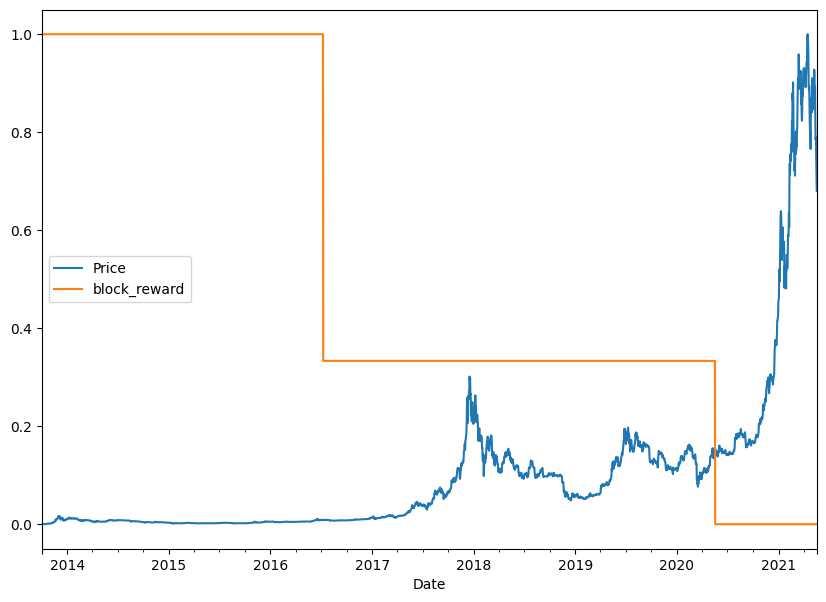

In [91]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                  columns = bitcoin_prices_block.columns,
                                                  index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.


In [92]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [93]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [94]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [95]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)


In [96]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 14s - loss: 4267.6602

18/18 [==============================] - 2s 61ms/step - loss: 2371.9634 - val_loss: 4197.0996
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 353.9646

18/18 [==============================] - 1s 31ms/step - loss: 353.9646 - val_loss: 944.8959
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 202.6169 - val_loss: 964.9858
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 232.9539

18/18 [==============================] - 1s 30ms/step - loss: 173.3837 - val_loss: 936.7810
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 181.4023

18/18 [==============================] - 1s 30ms/step - loss: 166.5762 - val_loss: 928.3501
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 126.4483

18/18 [==============================] - 1s 29ms/step - loss: 164.1692 - val_loss: 912.3115
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 204.1269

18/18 [==============================] - 1s 29ms/step - loss: 162.1504 - val_loss: 900.0295
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 142.2546

18/18 [==============================] - 1s 29ms/step - loss: 159.4458 - val_loss: 883.6320
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 157.4291 - val_loss: 886.9002
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 171.3507

18/18 [==============================] - 0s 29ms/step - loss: 151.9404 - val_loss: 840.2073
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 163.7185

18/18 [==============================] - 1s 36ms/step - loss: 148.1078 - val_loss: 816.8276
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 146.2467 - val_loss: 876.0472
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 144.5329

18/18 [==============================] - 1s 44ms/step - loss: 144.5329 - val_loss: 806.6025
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 140.5584 - val_loss: 806.8562
Epoch 15/100
18/18 [==============================] - 0s 9ms/step - loss: 142.4090 - val_loss: 808.2290
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 137.7105

18/18 [==============================] - 1s 36ms/step - loss: 137.7105 - val_loss: 759.1960
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 134.7705 - val_loss: 765.4673
Epoch 18/100
14/18 [======================>.......] - ETA: 0s - loss: 138.3103

18/18 [==============================] - 1s 65ms/step - loss: 132.2761 - val_loss: 748.0762
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 129.6517

18/18 [==============================] - 2s 110ms/step - loss: 129.6740 - val_loss: 746.0323
Epoch 20/100
18/18 [==============================] - 0s 11ms/step - loss: 133.9107 - val_loss: 746.7451
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 138.6372

18/18 [==============================] - 2s 105ms/step - loss: 132.0096 - val_loss: 714.2984
Epoch 22/100
14/18 [======================>.......] - ETA: 0s - loss: 134.9639

18/18 [==============================] - 1s 48ms/step - loss: 129.9275 - val_loss: 687.8563
Epoch 23/100
14/18 [======================>.......] - ETA: 0s - loss: 123.1323

18/18 [==============================] - 1s 73ms/step - loss: 125.6988 - val_loss: 682.7812
Epoch 24/100
18/18 [==============================] - 0s 18ms/step - loss: 127.2553 - val_loss: 704.9041
Epoch 25/100
10/18 [===============>..............] - ETA: 0s - loss: 130.5840

18/18 [==============================] - 1s 67ms/step - loss: 124.5528 - val_loss: 671.8137
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 120.7083

18/18 [==============================] - 1s 49ms/step - loss: 120.7083 - val_loss: 663.3250
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 176.2031

18/18 [==============================] - 1s 43ms/step - loss: 120.2680 - val_loss: 657.6715
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 118.4350

18/18 [==============================] - 1s 84ms/step - loss: 118.4350 - val_loss: 646.8369
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 114.0395

18/18 [==============================] - 1s 30ms/step - loss: 118.2262 - val_loss: 641.8837
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 134.3085

18/18 [==============================] - 1s 31ms/step - loss: 118.9267 - val_loss: 641.0722
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 119.8637 - val_loss: 735.8787
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 121.8804 - val_loss: 680.9048
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 115.8507 - val_loss: 674.0472
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 120.5379

18/18 [==============================] - 1s 45ms/step - loss: 116.4911 - val_loss: 620.6216
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 115.4600 - val_loss: 627.8577
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 123.7346 - val_loss: 702.9678
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 115.6901

18/18 [==============================] - 1s 43ms/step - loss: 116.0128 - val_loss: 609.1623
Epoch 38/100
18/18 [==============================] - 0s 18ms/step - loss: 113.4453 - val_loss: 610.4828
Epoch 39/100
18/18 [==============================] - 0s 13ms/step - loss: 114.2122 - val_loss: 648.1332
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 113.5191 - val_loss: 611.6439
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 114.3132 - val_loss: 663.8547
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 119.5573 - val_loss: 616.5251
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5629 - val_loss: 619.0557
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 68.8025

18/18 [==============================] - 1s 44ms/step - loss: 114.2156 - val_loss: 601.9525
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 82.5112

18/18 [==============================] - 1s 47ms/step - loss: 114.0037 - val_loss: 596.6559
Epoch 46/100
18/18 [==============================] - 0s 12ms/step - loss: 112.1423 - val_loss: 599.2716
Epoch 47/100
18/18 [==============================] - 0s 11ms/step - loss: 111.7643 - val_loss: 653.4869
Epoch 48/100
18/18 [==============================] - 0s 13ms/step - loss: 111.3091 - val_loss: 599.6485
Epoch 49/100
18/18 [==============================] - 0s 14ms/step - loss: 111.7696 - val_loss: 629.4296
Epoch 50/100
18/18 [==============================] - 0s 15ms/step - loss: 117.8503 - val_loss: 640.3774
Epoch 51/100
18/18 [==============================] - 0s 11ms/step - loss: 112.4439 - val_loss: 608.6095
Epoch 52/100
18/18 [==============================] - 0s 9ms/step - loss: 113.4186 - val_loss: 600.7625
Epoch 53/100
17/18 [===========================>..] - ETA: 0s - loss: 114.2684

18/18 [==============================] - 1s 59ms/step - loss: 113.7729 - val_loss: 584.7096
Epoch 54/100
18/18 [==============================] - 0s 11ms/step - loss: 112.1130 - val_loss: 610.9003
Epoch 55/100
17/18 [===========================>..] - ETA: 0s - loss: 112.8354

18/18 [==============================] - 1s 57ms/step - loss: 111.2309 - val_loss: 582.9244
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 110.8751 - val_loss: 795.7675
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 136.4850 - val_loss: 603.6572
Epoch 58/100
18/18 [==============================] - 0s 11ms/step - loss: 119.3998 - val_loss: 624.0964
Epoch 59/100
18/18 [==============================] - 0s 14ms/step - loss: 109.0794 - val_loss: 583.7922
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 109.1897 - val_loss: 590.7913
Epoch 61/100
18/18 [==============================] - 0s 12ms/step - loss: 109.7352 - val_loss: 596.4655
Epoch 62/100
11/18 [=================>............] - ETA: 0s - loss: 106.0801

18/18 [==============================] - 1s 51ms/step - loss: 110.1676 - val_loss: 582.7731
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 109.4065 - val_loss: 597.1293
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7727 - val_loss: 650.3526
Epoch 65/100
18/18 [==============================] - 0s 8ms/step - loss: 115.0401 - val_loss: 584.7873
Epoch 66/100
14/18 [======================>.......] - ETA: 0s - loss: 110.4187

18/18 [==============================] - 1s 50ms/step - loss: 111.4569 - val_loss: 580.2343
Epoch 67/100
18/18 [==============================] - 0s 9ms/step - loss: 108.1259 - val_loss: 612.6875
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss: 116.3416 - val_loss: 707.8636
Epoch 69/100
18/18 [==============================] - 0s 12ms/step - loss: 123.3306 - val_loss: 623.1071
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 121.8576 - val_loss: 598.9326
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4227 - val_loss: 619.5887
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0632 - val_loss: 593.2399
Epoch 73/100
18/18 [==============================] - ETA: 0s - loss: 108.6374

18/18 [==============================] - 2s 90ms/step - loss: 108.6374 - val_loss: 575.5775
Epoch 74/100
18/18 [==============================] - 0s 16ms/step - loss: 109.7401 - val_loss: 581.8757
Epoch 75/100
18/18 [==============================] - 0s 14ms/step - loss: 108.7928 - val_loss: 575.9448
Epoch 76/100
11/18 [=================>............] - ETA: 0s - loss: 110.7365

18/18 [==============================] - 1s 57ms/step - loss: 109.1782 - val_loss: 573.9838
Epoch 77/100
18/18 [==============================] - 0s 10ms/step - loss: 109.1442 - val_loss: 591.4562
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 108.5953 - val_loss: 581.7086
Epoch 79/100
18/18 [==============================] - 0s 10ms/step - loss: 108.9638 - val_loss: 630.3477
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 110.0384 - val_loss: 606.2695
Epoch 81/100
15/18 [========================>.....] - ETA: 0s - loss: 109.3460

18/18 [==============================] - 1s 51ms/step - loss: 108.1883 - val_loss: 571.1357
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 114.9444 - val_loss: 572.4858
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.7132 - val_loss: 677.7753
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2749 - val_loss: 589.0220
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8032 - val_loss: 589.5684
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 107.8987 - val_loss: 615.8180
Epoch 87/100
13/18 [====================>.........] - ETA: 0s - loss: 113.2281

18/18 [==============================] - 1s 42ms/step - loss: 109.9130 - val_loss: 569.4568
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6580 - val_loss: 574.7252
Epoch 89/100
14/18 [======================>.......] - ETA: 0s - loss: 102.5169

18/18 [==============================] - 1s 57ms/step - loss: 108.5986 - val_loss: 569.1516
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 106.5517 - val_loss: 607.0687
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 109.1268 - val_loss: 615.3886
Epoch 92/100
18/18 [==============================] - 0s 13ms/step - loss: 109.4987 - val_loss: 578.4311
Epoch 93/100
18/18 [==============================] - 0s 12ms/step - loss: 113.8843 - val_loss: 600.8043
Epoch 94/100
18/18 [==============================] - 0s 10ms/step - loss: 109.5897 - val_loss: 595.7711
Epoch 95/100
10/18 [===============>..............] - ETA: 0s - loss: 102.9386

18/18 [==============================] - 1s 60ms/step - loss: 107.1651 - val_loss: 568.7400
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3916 - val_loss: 621.9623
Epoch 97/100
18/18 [==============================] - 0s 8ms/step - loss: 110.1689 - val_loss: 599.0591
Epoch 98/100
18/18 [==============================] - 0s 8ms/step - loss: 111.8490 - val_loss: 571.1478
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 107.6558

18/18 [==============================] - 1s 51ms/step - loss: 109.3222 - val_loss: 568.0179
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2014 - val_loss: 651.4705


In [97]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 651.4705


651.4705200195312

In [98]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 568.0180


568.0180053710938

In [99]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8882.835, 8786.618, 9042.226, 8815.077, 8732.197, 8758.687,
       8690.213, 8545.258, 8467.074, 8538.738], dtype=float32)>

In [100]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.01807,
 'mse': 1178162.0,
 'rmse': 1085.4316,
 'mape': 2.5353162,
 'mase': 0.9978504}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well..) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture.
* Potentially get state of the art results on our problem

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing


In [101]:
# Create NBEATBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [102]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [103]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [104]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.03811505  0.1947688  -0.4317381  -0.22658925 -1.4687414  -0.52442235
 -0.5371042 ]
Forecast: 0.19818727672100067


### Preparing data for the N-BEATS algorithm using `tf.data`

In [105]:
HORIZON = 1
WINDOW_SIZE = 7

In [106]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [107]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [108]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [109]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18:  https://arxiv.org/pdf/1905.10437.pdf

In [110]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add)

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

In [111]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [113]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of N-BEATS block
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backward prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residuals stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 981: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1703: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1803: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 6min 40s, sys: 7.72 s, total: 6min 48s
Wall time: 7min 58s


In [114]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 33ms/step - loss: 570.9776


570.9776000976562

In [115]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8829.464, 8773.82 , 9048.021, 8744.688, 8776.705, 8752.449,
       8671.746, 8484.59 , 8493.668, 8520.042], dtype=float32)>

In [116]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 570.9776,
 'mse': 1155488.8,
 'rmse': 1074.9366,
 'mape': 2.6352727,
 'mase': 1.0030495}

Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

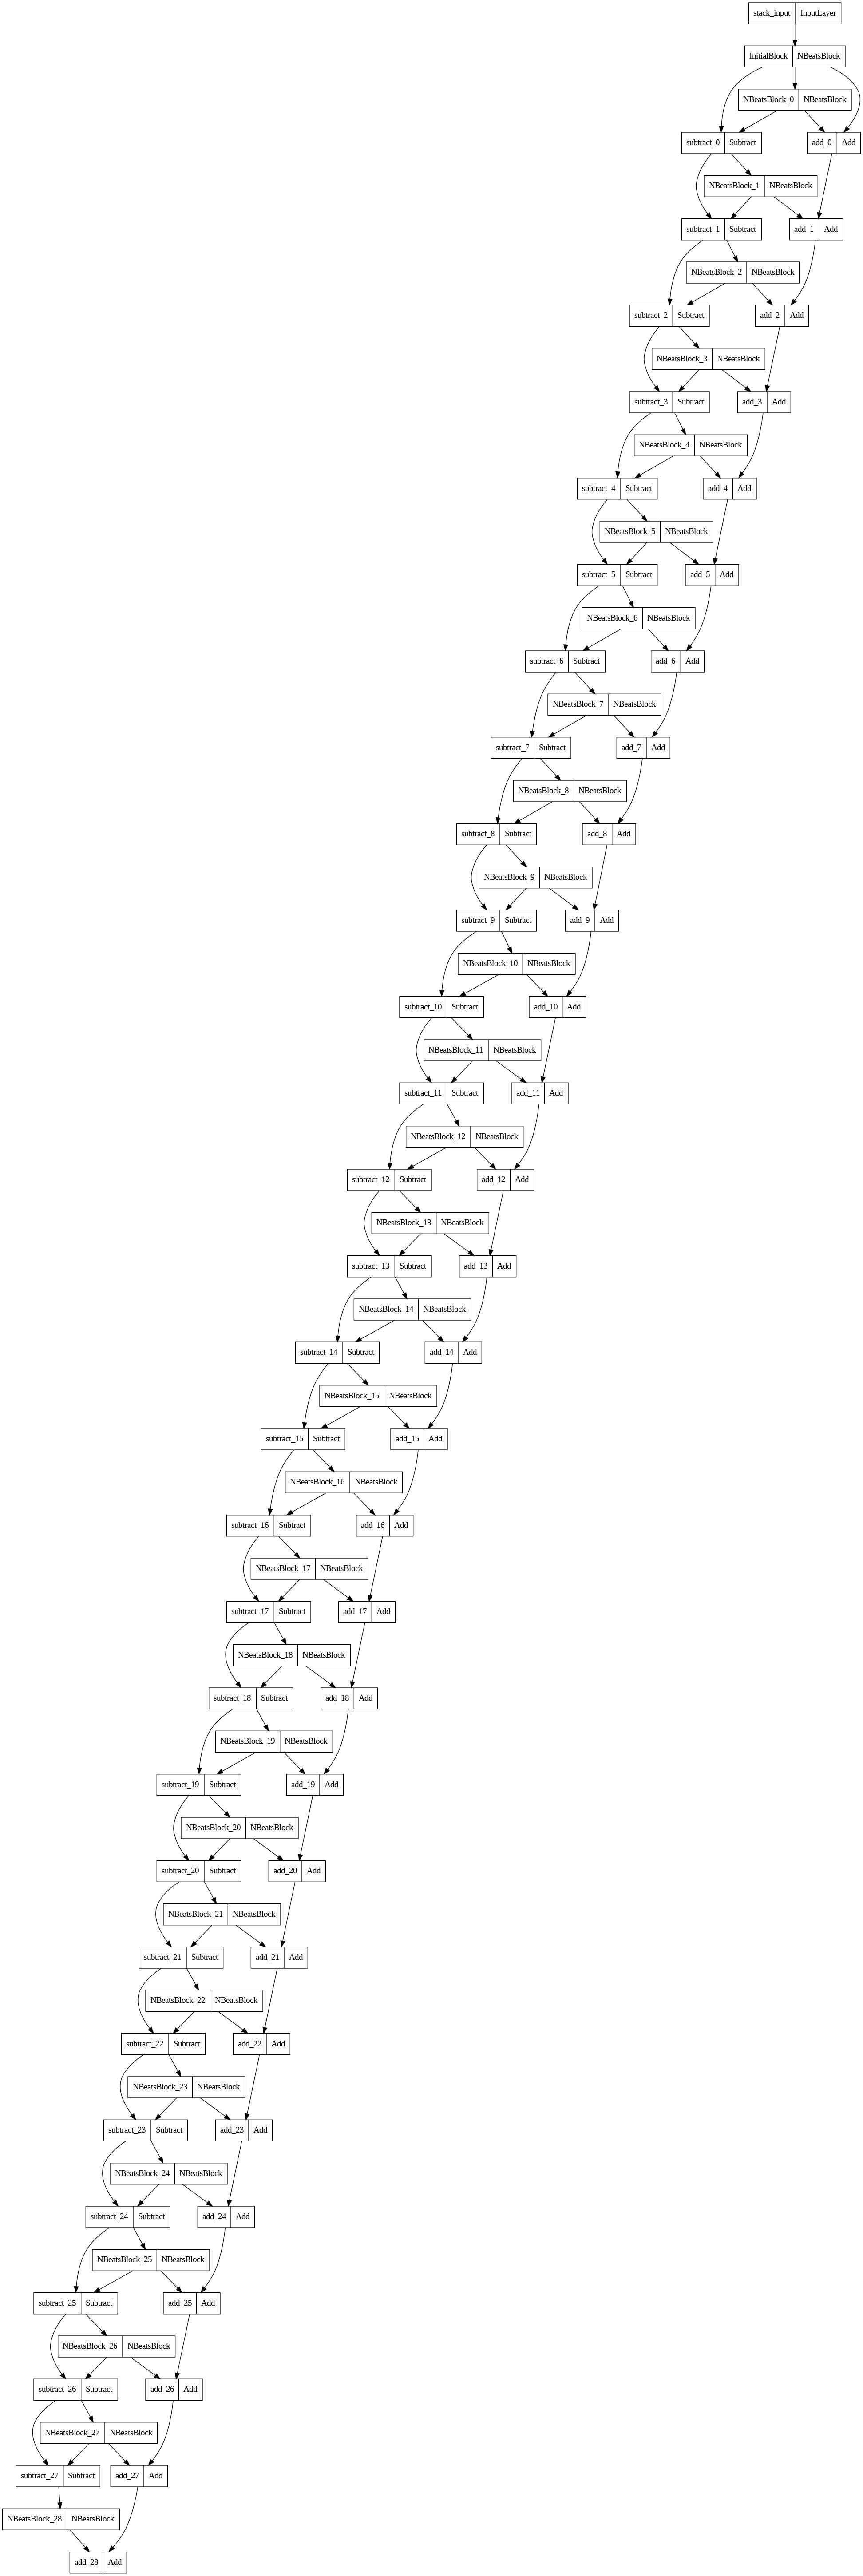

In [118]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [119]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)


In [121]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [122]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 781: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 881: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 577: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 677: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 156: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 517: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 617: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 563: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 723: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 823:

In [123]:
len(ensemble_models)

15

### Make predictions with our ensemble model

In [124]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds=[]
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [125]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 45ms/step
CPU times: user 764 ms, sys: 14.6 ms, total: 779 ms
Wall time: 906 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8776.176,  8761.005,  9002.12 , ..., 49561.906, 47897.746,
        46152.855],
       [ 8699.024,  8792.753,  9112.093, ..., 49993.14 , 47848.92 ,
        45828.992],
       [ 8796.928,  8803.522,  9035.137, ..., 50039.15 , 47939.74 ,
        46126.58 ],
       ...,
       [ 8729.426,  8714.658,  9002.953, ..., 49634.523, 48296.684,
        45839.543],
       [ 8840.37 ,  8764.379,  9015.714, ..., 49265.68 , 48375.664,
        45867.234],
       [ 8787.071,  8817.855,  9072.2  , ..., 50270.09 , 48057.824,
        46129.516]], dtype=float32)>

In [129]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8773.671, 8768.792, 9053.006, 8721.822, 8739.262, 8713.69 ,
       8635.132, 8484.351, 8439.652, 8511.567], dtype=float32)>

In [130]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8781.896, 8776.282, 9049.691, 8722.802, 8740.037, 8731.667,
       8642.985, 8480.353, 8451.434, 8517.28 ], dtype=float32)

In [127]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 578.9182,
 'mse': 1172026.5,
 'rmse': 1082.5543,
 'mape': 2.6333327,
 'mase': 1.016999}

In [131]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 565.573,
 'mse': 1143293.5,
 'rmse': 1069.249,
 'mape': 2.5599034,
 'mase': 0.9935551}

In [132]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 566.54376,
 'mse': 1140449.9,
 'rmse': 1067.9185,
 'mape': 2.5617046,
 'mase': 0.9952605}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

To get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [133]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

In [135]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

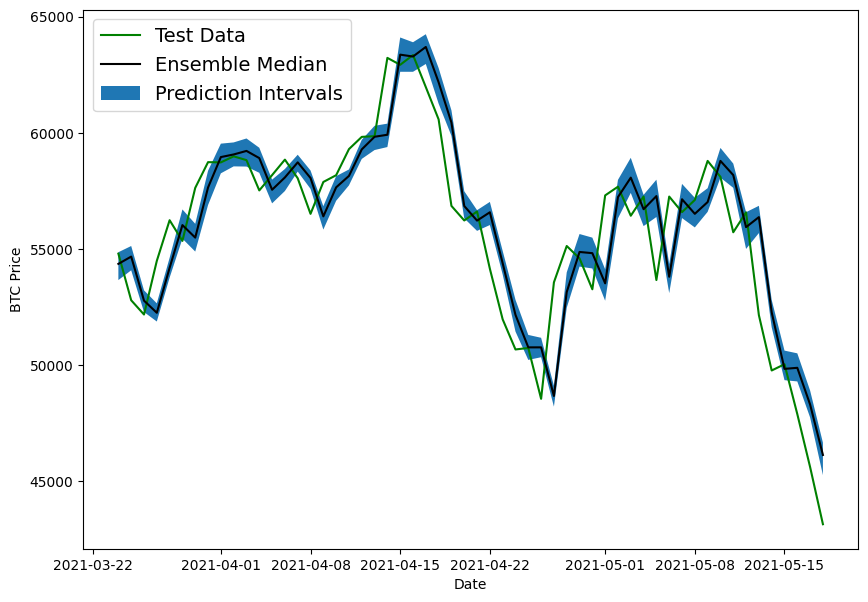

In [138]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between()
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

So far all of our models predictions have been lagging behing the test data...

As in they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as data uncertainty or subway uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty



## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

In [ ]:
bitcoin_prices_windowed.tail()

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile
model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions into future

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
 * a list of values (Bitcoin historical data)
 * a trained model (such as `model_9`)
 * a window into the future to predict (our `INTO_FUTURE` variable)
 * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecast (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction


In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

### Plot future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start_date and "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date = last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index,
                 btc_price,
                 start=2500,
                 format="-",
                 label="Actual BTC Price")
plot_time_series(next_timesteps,
                 future_forecast,
                 format="-",
                 label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem )

In [ ]:
# Let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

### Build a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(model_name=turkey_model.name)])

In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [ ]:
# Evaluate the turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

In [ ]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data",
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset)

## Compare models

In [ ]:
# Compare different model results (w = windows, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T

model_results.head(10)

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")